<a href="https://colab.research.google.com/github/anasbn44/stock_prediction/blob/master/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock prediction using ML models

Predicting stock market movements using machine learning models has gained significant attention in recent years due to the potential for improved accuracy and predictive power. By leveraging historical price data, financial indicators, and other relevant features, ML models can help identify patterns and make predictions about future stock prices.

## Outlines
- [1. Packages](#1)
- [2. Preprocessing](#2)
    - [2.1. Data importation](#2.1)
    - [2.2. Data Checking](#2.2)
    - [2.3. Feature engineering](#2.3)
- [3. Linear Regression](#3)
    - [3.1. L.R. with all features from scratch](#3.1)
    - [3.2. L.R. with scikit-learn](#3.2)
    - [3.3. L.R. with best selected features](#3.3)
- [4. Models comparison](#4)
- [5. Conclusion](#5)

<a name="1"></a>
### 1. Packages
- [numpy](https://numpy.org/) package for scientific computing.
- [pandas](https://pandas.pydata.org/ ) data analysis and manipulation library.
- [matplotlib](http://matplotlib.org) visualization library.
- [seaborn](https://seaborn.pydata.org/) statistical data visualization
- [scikitlearn](https://scikit-learn.org/stable/) machine learning library that supports supervised and unsupervised learning.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/) optimized distributed gradient boosting library.

In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.feature_selection import SelectKBest,f_regression

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

<a name="2"></a>
### 2. Preprocessing

<a name="2.1"></a>
#### 2.1. Data importation
In this project, we have decided to construct our regression models with only the following indexes ;
- AAPL is the index of apple.
- AMZN is the index of amazon.
- FB is the index of facebook.

We imported data from [kaggle](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data) which provided us a clean data. The data is loaded into separate Pandas DataFrame objects. These DataFrames contain columns representing various attributes of the stocks, such as date, opening price, closing price, volume, etc. 

In [ ]:
data_aapl = pd.read_csv("AAPL.csv")
data_amzn = pd.read_csv("AMZN.csv")
data_fb = pd.read_csv("FB.csv")

stocks = [x for x in [data_aapl, data_amzn, data_fb]]
names=[("AAPL","sp500"),("AMZN","sp500"),("FB","sp500")]

for s in stocks :
    print(f"{s.tail(10)}")

             Date         Low        Open    Volume        High       Close  \
10372  01-02-2022  172.309998  174.009995  86213900  174.839996  174.610001   
10373  02-02-2022  173.330002  174.750000  84914300  175.880005  175.839996   
10374  03-02-2022  172.119995  174.479996  89418100  176.240005  172.899994   
10375  04-02-2022  170.679993  171.679993  82391400  174.100006  172.389999   
10376  07-02-2022  170.949997  172.860001  77251200  173.949997  171.660004   
10377  08-02-2022  171.429993  171.729996  74829200  175.350006  174.830002   
10378  09-02-2022  174.899994  176.050003  71285000  176.649994  176.279999   
10379  10-02-2022  171.550003  174.139999  90865900  175.479996  172.119995   
10380  11-02-2022  168.039993  172.330002  98566000  173.080002  168.639999   
10381  14-02-2022  167.139999  167.369995  25398134  169.000000  168.699997   

       Adjusted Close  
10372      174.387817  
10373      175.616257  
10374      172.679993  
10375      172.389999  
10376     

<a name="2.2"></a>
#### 2.2. Data Checking
Before any feature creation, first, we check that there is no null values and we concuded the data is clean.

In [ ]:
for i,stock in enumerate(stocks):
    print(f"index : {names[i][0]}")
    print(stock.info())
    print(stock.isnull().sum())
    print(stock.describe())


index : AAPL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10382 entries, 0 to 10381
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10382 non-null  object 
 1   Low             10382 non-null  float64
 2   Open            10382 non-null  float64
 3   Volume          10382 non-null  int64  
 4   High            10382 non-null  float64
 5   Close           10382 non-null  float64
 6   Adjusted Close  10382 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 567.9+ KB
None
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64
                Low          Open        Volume          High         Close  \
count  10382.000000  10382.000000  1.038200e+04  10382.000000  10382.000000   
mean      13.426372     13.571913  3.327950e+08     13.717826     13.577412   
std       28.91

<a name="2.3"></a>
#### 2.3. Feature engineering

As you can see, each day's moving average is calculated by taking the average of the closing prices 
of the previous three days. The moving average smooths out the daily fluctuations and provides
a trend of the stock's price over time.

For example, if a shorter-term moving average (e.g., 10-day) and a longer-term moving average (e.g., 100-day) both show an upward trend, it strengthens the conviction that an upward trend is underway.

We also calculate the maximum and minimum values within the specified number of days. The maximum and minimum values provide insights into the stock's price behavior, trends, trading opportunities, and volatility. These calculations provide valuable information for making informed decisions and formulating effective trading or investment strategies.

In [ ]:
ma_days = [7,10,14,21,50,100]
maxi_days=[7,30,365,730]

def calculate_average(data,no_days):
    for ma in no_days:
        column_name = "MA for %s days" %(str(ma))
        data.loc[:,column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

def calculate_maximum(data,no_days):
    for ma in no_days:
        column_name = "Maximum for %s days" %(str(ma))
        data.loc[:,column_name]=pd.DataFrame.rolling(data['Close'],ma).max()

def calculate_minimum(data,no_days):
    for ma in no_days:
        column_name = "Minimum for %s days" %(str(ma))
        data.loc[:,column_name]=pd.DataFrame.rolling(data['Close'],ma).min()


for s in stocks :
    calculate_average(s,ma_days)
    calculate_maximum(s,maxi_days)
    calculate_minimum(s,maxi_days)
    s.loc[:,"std for 7 days"]=pd.DataFrame.rolling(s['Close'],7).std()
    #add difference high-low daily feature
    s.loc[:,'Diff High Low']=s['High']-s['Low']
    #add diff open-close feature
    s.loc[:,'Diff Open Close']=s['Open']-s['Close']
    s.loc[:,'Daily Return'] = s['Close'].pct_change()*100

    print("number of features {}".format(len(s.columns)))
    

print(f"columns names{stocks[0].columns}")

number of features 25
number of features 25
number of features 25
columns namesIndex(['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close',
       'MA for 7 days', 'MA for 10 days', 'MA for 14 days', 'MA for 21 days',
       'MA for 50 days', 'MA for 100 days', 'Maximum for 7 days',
       'Maximum for 30 days', 'Maximum for 365 days', 'Maximum for 730 days',
       'Minimum for 7 days', 'Minimum for 30 days', 'Minimum for 365 days',
       'Minimum for 730 days', 'std for 7 days', 'Diff High Low',
       'Diff Open Close', 'Daily Return'],
      dtype='object')



We decided to choose the last 6 years for the data set because the data, in the early years, is stagnant.
.

In [ ]:
for index,stock in enumerate(stocks):
    stock['Date'] = pd.to_datetime(stock['Date'],dayfirst=True)
    start_date=pd.to_datetime("01/01/2012")
    end_date=pd.to_datetime("01/01/2022")
    stock = stock[(stock["Date"] >= start_date) & (stock["Date"] <= end_date)]
    stock.set_index('Date', inplace=True)
    stocks[index]=stock
df=stocks[0]

Plotting the evolution of Close price of the three stocks ; "AAPL", "AMZN" and "FB" starting from 2012 to 2022.

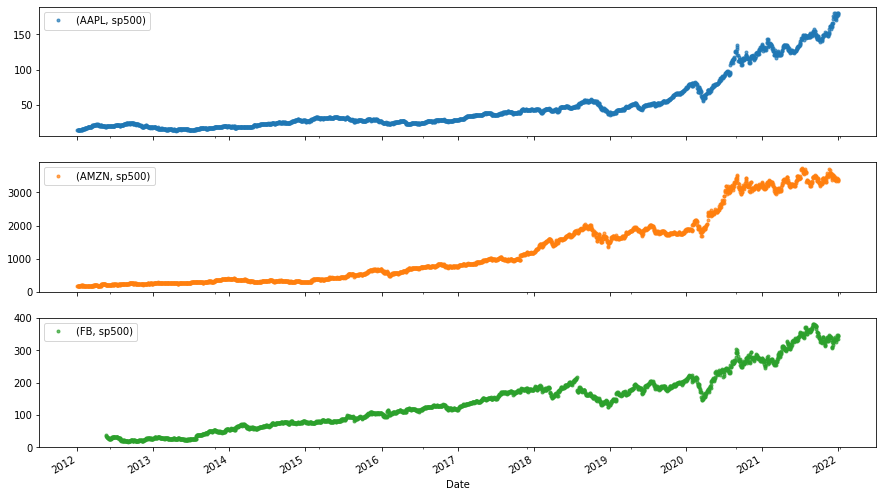

In [ ]:
stocks_close=[stock["Close"] for stock in stocks]
close_show = pd.concat(stocks_close, axis=1, keys=names)
axes =close_show.plot(marker='.', alpha=0.7, linestyle='None', figsize=(15, 9), subplots=True)

In [ ]:
#to avoid unnecessary warnings
warnings.filterwarnings("ignore")

We extract the input and output from the dataset. We add a new column "Previous Close" that represents the "Close" price of the previous day.

In [ ]:
aapl_data = stocks[0]
y = aapl_data['Close'][1:] #target column -close value
aapl_data.loc[:,'Close previous']=aapl_data['Close']
aapl_data=aapl_data.drop(['Close'],axis=1)
aapl_data=aapl_data.drop(['Adjusted Close'],axis=1)
aapl_data=aapl_data.shift(periods=1)[1:]

print(aapl_data['Close previous'].tail(3))
print("-----------------")
print(stocks[0]['Close'].tail(4))

Date
2021-12-29    179.289993
2021-12-30    179.380005
2021-12-31    178.199997
Name: Close previous, dtype: float64
-----------------
Date
2021-12-28    179.289993
2021-12-29    179.380005
2021-12-30    178.199997
2021-12-31    177.570007
Name: Close, dtype: float64


<a name="3"></a>
### 3. Linear Regression

<a name="3.1"></a>
#### 3.1. L.R. with all features from scratch

First Step is to split the data into training data and testing data. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(aapl_data, y, test_size=0.25, shuffle=False)

print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")

print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (1887, 23)
the shape of the training set (target) is: (1887,)

the shape of the test set (input) is: (629, 23)
the shape of the test set (target) is: (629,)


The purpose of scaling is to ensure that all features contribute equally to the learning process and to avoid any bias or dominance of features based on their scale or unit of measurement. 

Min-max scaling: This estimator scales and translates each feature individually such that it is to a specific range, often between 0 and 1.

The transformation is given by:
$$ Z = \frac{(X - \mathbf{\min})}{\mathbf{\max} - \mathbf{\min}}
$$
where min, max = feature_range.

first, we compute the min and max of the training set then transform it unsing [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform) method.

We will scale also the test set below by using the same `MinMaxScaler` but only calling its [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) method instead of [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform)

In [ ]:
scaler = MinMaxScaler()
#Compute the min and max of the training set then transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Defining the model of the Linear Regression
$$ f_{w,b}(x^{(i)}) = wx^{(i)} + b $$

In [ ]:
def model(X, theta):
    return X.dot(theta) 

The cost function computes the squared difference between the predicted value ŷᵢ and the true value yᵢ for each training example, sums up these squared differences, and then divides by the total number of training examples to calculate the average.
$$ J_\text{train}(\mathbf{w},b) =
            \frac{1}{2m_\text{train}}\sum_{i=0}^{m_\text{train}-1} ( f_{\mathbf{w},b}(\mathbf{X}^{(i)}_\text{train}) - y^{(i)}_\text{train} )^2
$$

In [ ]:
def cost_function(X, y, theta):
    m = len(y)
    return 1/(2*m) * np.sum((model(X, theta) - y)**2)

Gradient function for computing the gradient of the cost function with respect to the model parameters (theta) in linear regression. 
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

In [ ]:
def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

 Gradient descent is an iterative optimization algorithm used to minimize the cost or error function of a model by updating its parameters.
 $$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously. 

In [ ]:
def gradient_descent(X, y, theta, learning_rate, n_iterations):
    
    cost_history = np.zeros(n_iterations) # création d'un tableau de stockage pour enregistrer l'évolution du Cout du modele
    
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta) # mise a jour du parametre theta (formule du gradient descent)
        cost_history[i] = cost_function(X, y, theta) # on enregistre la valeur du Cout au tour i dans cost_history[i]
        if (i + 1) % (n_iterations/10) == 0:
            print(f"iteration {i} : {cost_history[i]}")
        
    return theta, cost_history

In [ ]:
#Initialising a random theta
theta = np.random.randn(23, 1)
theta

array([[ 0.88879256],
 [-1.4474185 ],
 [ 0.68425771],
 [-1.64761688],
 [ 0.72139603],
 [ 1.11073293],
 [ 0.73825054],
 [ 0.84211292],
 [ 0.4158743 ],
 [-0.10738561],
 [-0.7927478 ],
 [-0.87444944],
 [ 0.54123971],
 [-0.09090662],
 [-1.37124883],
 [ 0.12702957],
 [-1.92435937],
 [ 1.35937527],
 [-2.37579772],
 [-0.49044223],
 [-1.42798766],
 [ 0.64482403],
 [ 0.13633345]])

In [ ]:
#reshaping y_train into two-dimensionnal array
y_train = np.reshape(y_train.values,(-1,1))
print(y_train.shape)

(1887, 1)


In [ ]:
#calculating the initial cost of the model
cost_function(X_train_scaled,y_train,theta)

545.6883452649482

Training the model with a learning rate of 0.1 and number of iterations as 6000.

In [ ]:
n_iterations = 6000
learning_rate = 0.1

theta_final, cost_history = gradient_descent(X_train_scaled, y_train, theta, learning_rate, n_iterations)

theta_final

iteration 599 : 0.63400807091653
iteration 1199 : 0.5264746295022079
iteration 1799 : 0.4846435130028694
iteration 2399 : 0.4610821384441227
iteration 2999 : 0.44681973302069533
iteration 3599 : 0.43777438215742676
iteration 4199 : 0.43176062200927123
iteration 4799 : 0.4275607997140649
iteration 5399 : 0.4244802757692318
iteration 5999 : 0.42211453702847024


array([[ 7.38056113],
 [ 4.1802146 ],
 [ 2.23051354],
 [ 4.23369623],
 [ 5.34875571],
 [ 4.47784878],
 [ 3.08504549],
 [ 1.85654336],
 [-1.13265337],
 [-1.62421868],
 [ 3.3817593 ],
 [-0.81628602],
 [ 0.8931724 ],
 [ 0.79583755],
 [ 3.25416228],
 [ 1.02566631],
 [-0.40429534],
 [ 2.00492181],
 [ 0.14918162],
 [-1.4973013 ],
 [ 9.1275823 ],
 [14.54440479],
 [ 6.79753482]])

In [ ]:
#predicting the close price with the test data.
predictions = model(X_test_scaled, theta_final)

In [ ]:
#calculating the coefficient of determination.
r2_score(y_test, predictions)

0.9856460490801576

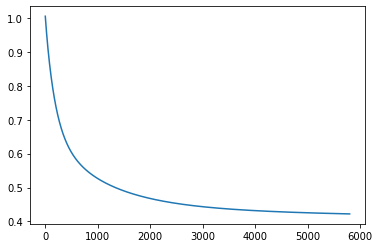

In [ ]:
#plotting the evolution of errors.
plt.plot(range(6000-200), cost_history[200:])
plt.show()

<a name="3.2"></a>
#### 3.2. L.R. with scikit-learn

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
#defining the model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression() In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LinearRegression LinearRegression()

In [ ]:
#Once trained, the model is used to make predictions on test data.
yhat = linear_model.predict(X_test_scaled)

In [ ]:
#calculate the coefficient of determination (R-squared) of the trained linear regression model.
score = linear_model.score(X_test_scaled, y_test)
score

0.9960251560134215

<a name="3.3"></a>
#### 3.3. L.R. with best selected features

Select features according to the k highest scores with [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html). Then, we plot the ten highest scored features and the selected features with a heatmap. 

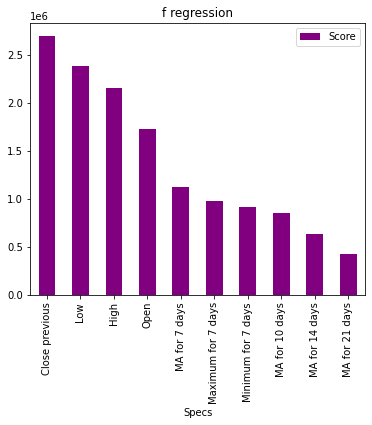

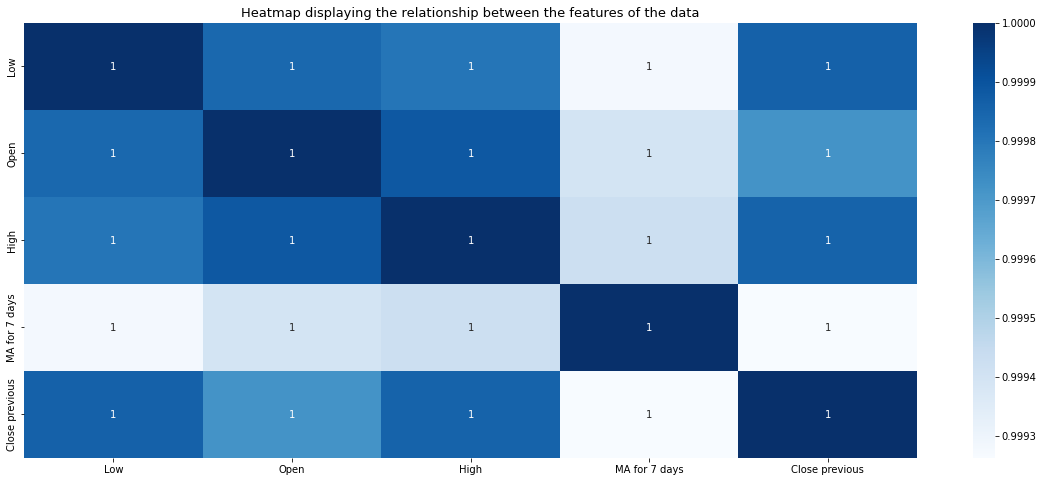

In [ ]:
def select_k_features(func,k=5,x=aapl_data.copy(), y_=y.copy()):
    #apply SelectKBest class to extract top 5 best features
    bestfeatures = SelectKBest(score_func=func, k=5)
    fit = bestfeatures.fit(x,y_)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    feature_scores = pd.concat([dfcolumns, dfscores], axis=1)
    feature_scores.columns = ['Specs', 'Score']  #naming the dataframe columns
    feature_scores.nlargest(10, 'Score').plot.bar(x="Specs", y="Score", figsize=(6, 5), color="purple")
    plt.title("f regression")
    plt.show()
    best_5=list(feature_scores.nlargest(5, 'Score')['Specs'])
    for col in x:
        if col not in best_5:
            x.drop([col], axis=1, inplace=True)
    return x

X_best=select_k_features(func=f_regression)


plt.figure(figsize=(20,8))
sns.heatmap(X_best.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

We split the data again, after selecting the best features. Because our model is time series, shuffle parameter must be false because every value depended on the previous one.

In [ ]:
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best.values, y.values, test_size=0.25, shuffle=False)

print(f"the shape of the training set (input) is: {X_train_best.shape}")
print(f"the shape of the training set (target) is: {y_train_best.shape}\n")

print(f"the shape of the test set (input) is: {X_test_best.shape}")
print(f"the shape of the test set (target) is: {y_test_best.shape}")

the shape of the training set (input) is: (1887, 5)
the shape of the training set (target) is: (1887,)

the shape of the test set (input) is: (629, 5)
the shape of the test set (target) is: (629,)


Normalization of the dataset with min-max scalar

In [ ]:
scaler_best = MinMaxScaler()
X_train_scaled_best = scaler_best.fit_transform(X_train_best)
X_test_scaled_best = scaler_best.transform(X_test_best) 

In [ ]:
#Training the model.
model_best = LinearRegression()
model_best.fit(X_train_scaled_best, y_train_best)

LinearRegression() In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LinearRegression LinearRegression()

In [ ]:
#Predicting with the test data.
yhat_best = model_best.predict(X_test_scaled_best)
yhat_best

array([ 51.07779723, 49.98202288, 50.27518479, 50.80323401,
 50.51252836, 50.84020532, 51.32445241, 51.16288957,
 50.89852124, 51.39826656, 50.72634801, 51.75652482,
 52.1839843 , 52.16928232, 51.80335299, 52.0070676 ,
 52.45269105, 52.20177062, 53.45922925, 52.29471758,
 50.96165997, 48.3671213 , 49.16570151, 49.63880157,
 50.78064927, 50.25195421, 50.15919142, 52.22935233,
 50.82809683, 50.45255563, 51.61258445, 52.69409831,
 52.72030788, 53.18054048, 53.13399062, 50.79543706,
 51.60707074, 51.09726103, 51.33324695, 52.19724526,
 52.1761231 , 51.40881876, 52.27025608, 53.33414277,
 53.33959066, 53.51409898, 54.06634519, 55.82968206,
 55.89115395, 54.68344289, 54.95047191, 55.14613632,
 55.6142988 , 55.30829399, 54.52668977, 54.67984866,
 54.51332047, 55.18386858, 54.97769329, 54.69589524,
 55.97808957, 56.28439474, 54.78969009, 55.03790019,
 56.70251721, 56.86625756, 56.21773884, 56.7507288 ,
 57.49743522, 59.06000376, 59.05816571, 58.9044657 ,
 58.61773845, 58.80143845, 59.11377107, 60.1038585 ,
 60.05647219, 60.76972176, 60.87568413, 61.60279294,
 62.24220205, 60.92314589, 60.78118627, 61.78947496,
 63.86100933, 64.34543747, 64.3235892 , 64.28125067,
 64.8802608 , 64.963052 , 65.50298364, 65.50370652,
 66.0827691 , 65.71065677, 66.39135037, 66.71756843,
 66.57945356, 65.74342393, 65.50426188, 65.43862551,
 66.52720693, 66.05671545, 66.92800056, 66.81488062,
 66.10242852, 64.74631519, 65.45968591, 66.3384109 ,
 67.64405601, 66.74180406, 67.08836905, 67.67660262,
 67.8336613 , 68.72413328, 69.97847211, 70.13806253,
 70.01203869, 70.03264615, 69.89569002, 70.95432517,
 71.04281622, 72.40680335, 72.53701361, 72.73665876,
 73.35010254, 75.01383918, 74.46569366, 74.81676514,
 74.63595109, 75.74794803, 77.38550434, 77.61070452,
 79.16606707, 78.27017547, 77.91721728, 78.74851327,
 79.60217651, 79.20560983, 79.48414802, 79.71352267,
 79.69858512, 77.12396953, 79.33449778, 81.11969945,
 80.85648116, 77.55110729, 77.14610259, 79.61404589,
 80.35497217, 81.18026661, 80.00825758, 80.24146708,
 79.9431241 , 81.7062707 , 81.22677098, 81.19949853,
 79.66022943, 80.86986904, 80.09286812, 78.28353382,
 74.34684875, 72.11719419, 73.17708638, 68.55861524,
 68.09483798, 74.32100026, 72.44632908, 75.50941787,
 73.38091734, 72.15878481, 66.8309799 , 70.88446802,
 68.85026117, 62.58346091, 68.83012623, 61.00084849,
 62.87775839, 61.49653802, 61.31937952, 57.66257077,
 55.61507259, 61.4898583 , 61.72355578, 64.44862675,
 62.13664378, 63.64523399, 63.7946544 , 60.30354168,
 60.99886861, 60.3628894 , 65.40909036, 65.1024419 ,
 66.49822227, 66.9855605 , 68.19139672, 71.67942304,
 71.12208642, 71.58812836, 70.59556504, 69.37841489,
 67.09849911, 68.97270919, 68.97565201, 70.64338006,
 70.76601624, 69.7746298 , 71.95055614, 73.383676 ,
 72.59058542, 73.14202178, 74.48159706, 75.22556578,
 75.96326143, 77.44480602, 78.71229032, 78.03644715,
 76.95358105, 77.17825963, 76.77688357, 78.66193062,
 78.44911463, 79.78971609, 79.3022416 , 79.67368401,
 79.31803695, 79.39065805, 79.68454889, 79.51687708,
 80.39064457, 80.72787781, 81.2332636 , 80.60156395,
 82.75037396, 83.21827274, 85.8760749 , 88.18533975,
 84.24677584, 84.73114952, 85.63683558, 87.80707528,
 87.96529296, 87.91722402, 87.40717964, 89.61524558,
 91.77833187, 90.18781885, 91.02884454, 88.57301797,
 90.21384926, 91.15417116, 91.12105875, 91.17112556,
 93.48610183, 93.3430407 , 95.28215808, 95.65409613,
 95.80721639, 95.97514026, 96.77555381, 97.66785123,
 96.54590076, 96.30526806, 98.18280201, 97.10547699,
 97.30912557, 92.92836069, 92.17875355, 94.67802735,
 93.31416373, 94.95717702, 95.99600612, 105.83498142,
 109.39486265, 109.80207995, 110.08193318, 113.71820636,
 111.22207455, 112.47143202, 109.5414055 , 112.82668388,
 115.0648923 , 114.63863642, 114.61093723, 115.48916596,
 115.89566411, 118.118046 , 124.13640379, 125.84234212,
 124.65669683, 126.44287976, 125.02121104, 124.90042405,
 128.98899959, 133.88279688, 131.1813957 , 121.3814388 ,
 119.69068032, 113.41687327, 117.13748379, 113.65

In [ ]:
#calculating the coefficient of the determination
score_best = model_best.score(X_test_scaled_best,y_test_best)
score_best

0.9962618711978265

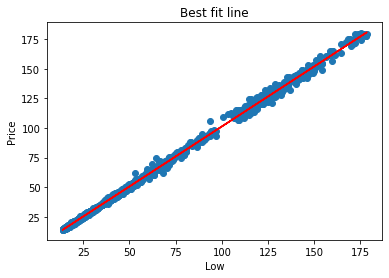

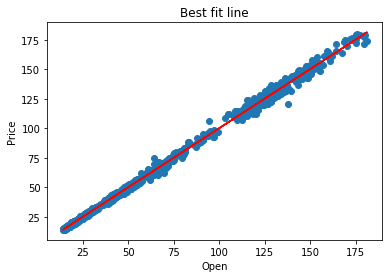

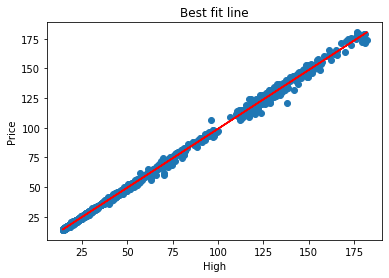

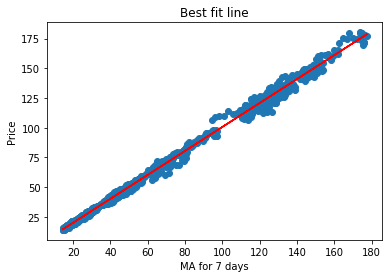

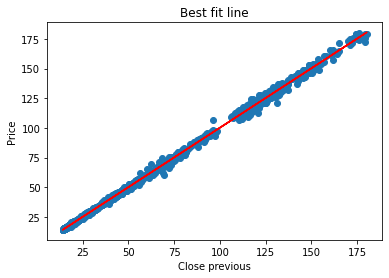

In [ ]:
#plotting the best fit line for every feature
model_plot = LinearRegression()
for i,e in enumerate(X_best.columns):
    model_plot.fit(X_best[e].values[:,np.newaxis], y)
    plt.title("Best fit line")
    plt.xlabel(str(e))
    plt.ylabel('Price')
    plt.scatter(X_best[e].values[:,np.newaxis], y)
    plt.plot(X_best[e].values[:,np.newaxis], model_plot.predict(X_best[e].values[:,np.newaxis]),color='r')
    plt.show()

Testing the model with new manually added data to get the predicted close price. To get right output, we had to scale the new data. 

In [ ]:
#new data 
new_data =np.array([178.089996, 179.470001, 180.570007, 177.444286, 178.199997]).reshape((1,-1))
new_data_scaled = scaler_best.transform(new_data)
new_data_scaled

array([[3.76129664, 3.77778236, 3.77127878, 3.83530125, 3.72708171]])

In [ ]:
#predicting the new close price
yhat_best_0 = model_best.predict(new_data_scaled)

yhat_best_0

array([178.39420159])

<a name="4"></a>
### 4. Models comparison
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.
- [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
- [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) Regression based on k-nearest neighbors.
- [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) A decision tree regressor.
- [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html) powerful regression algorithm that leverages gradient boosting techniques and efficient implementation.

In [ ]:
sc = ('Scaler', MinMaxScaler())
models =[]
models.append(('LinearRegression', Pipeline([sc, ('LinearRegression', LinearRegression())])))
models.append(('Ridge', Pipeline([sc, ('Ridge', Ridge())])))
models.append(('GradientBoosting', Pipeline([sc, ('GradientBoosting', GradientBoostingRegressor())])))
models.append(('ExtraTree', Pipeline([sc, ('ExtraTrees', ExtraTreesRegressor())])))
models.append(('RandomForest', Pipeline([sc, ('RandomForest', RandomForestRegressor())]))) 
models.append(('KNeighbors', Pipeline([sc, ('KNeighbors', KNeighborsRegressor())])))
models.append(('DecisionTree', Pipeline([sc, ('DecisionTree', DecisionTreeRegressor())])))
models.append(('XGB', Pipeline([sc, ('XGB', XGBRegressor())])))

[kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is a cross-validation technique used to assess the performance and generalization of a model. It is commonly used to estimate the model's performance on unseen data by splitting the dataset into k folds or subsets. By rotating the folds, the model is trained and evaluated on different subsets of the data.

In [ ]:
splits = 7
score = 'r2'
models_score =[]
for i in models:
    kfold = KFold(n_splits=splits)
    results = cross_val_score(i[1], X_train_best, y_train, cv=kfold, scoring=score)
    models_score.append({i[0] : '{} +/- {}'.format(results.mean(), results.std())})

We print the validation score for each fold ; the mean score and the standard deviation.

In [ ]:
models_score

[{'LinearRegression': '0.9766976084686879 +/- 0.010417991489582515'},
 {'Ridge': '0.9723157223052689 +/- 0.012559334997232814'},
 {'GradientBoosting': '0.9014212922497424 +/- 0.15277332242495933'},
 {'ExtraTree': '0.8984884408394443 +/- 0.1616842190124274'},
 {'RandomForest': '0.9008877221283429 +/- 0.14608870328909157'},
 {'KNeighbors': '0.9010099346961679 +/- 0.14746037379119054'},
 {'DecisionTree': '0.8691981706758762 +/- 0.15945493048131862'},
 {'XGB': '0.8961301750443492 +/- 0.154666884051361'}]

<a name="5"></a>
### 5. Conclusion

These values provide an indication of the performance and variability of each model. Thus, Linear Regression is the most suitable model of our stock prediction case ;  it provides interpretable coefficients and efficient analyzing of large datasets with multiple features.